In [4]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from util import bin_to_cell, plot_latent_space
from util import VAE, Sampling, FeaturePrediction, Pathfinder
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from dtw import dtw, rabinerJuangStepPattern
from itertools import product, combinations
from geopy.distance import geodesic
from tqdm import tqdm
# pip install pillow
# conda install cudnn
# conda install graphviz

# matplotlib v3.2
# conda install -c anaconda basemap
# conda install -c conda-forge basemap-data-hires
if sys.platform == "linux" or sys.platform == "linux2":
    # linux
    import conda
    os.environ["PROJ_LIB"] = os.path.join(conda.__file__.split('lib')[0], 'share', 'proj')
elif sys.platform == "darwin":
    # OS X
    # manually link proj4
    os.environ["PROJ_LIB"] = '/Users/ian/opt/<USERNAME>/envs/routing/bin/proj'
elif sys.platform == "win32":
    # Windows
    # manually link proj4
    os.environ["PROJ_LIB"] = 'C:\\Users\\<USERNAME>\\.conda\\pkgs\\proj-6.2.1-h9f7ef89_0'
else:
    print('Unknown OS:', sys.platform)
from mpl_toolkits.basemap import Basemap

In [5]:
# Load the dataset
# jobs     : noon report
# traces   : per minute latitude/longitude
# dist_mtx : distance matrix for convinience (described later)

with open('dataset.pkl', 'rb') as f:
    jobs, traces, dist_mtx = pickle.load(f)

In [6]:
print('Total number of jobs/traces/routes:', jobs.shape[0])

Total number of jobs/traces/routes: 405


In [7]:
# explore jobs

jobs

,consumed,start,stop,duration,lat0,lat1,lon0,lon1
0,190,2020-04-11 10:00:00+08:00,2020-04-11 11:00:00+08:00,0 days 01:00:00,1.310971,1.310971,103.646698,103.646698
1,197,2020-04-13 17:30:00+08:00,2020-04-13 18:45:00+08:00,0 days 01:15:00,1.310971,1.310971,103.646698,103.646698
2,570,2020-04-14 13:00:00+08:00,2020-04-14 16:00:00+08:00,0 days 03:00:00,1.310971,1.310971,103.646698,103.646698
3,380,2020-04-15 08:00:00+08:00,2020-04-15 10:00:00+08:00,0 days 02:00:00,1.310971,1.310971,103.646698,103.646698
4,195,2020-04-16 07:00:00+08:00,2020-04-16 08:10:00+08:00,0 days 01:10:00,1.310971,1.310971,103.646698,103.646698
...,...,...,...,...,...,...,...,...
400,1816,2020-10-28 07:00:00+08:00,2020-10-28 15:00:00+08:00,0 days 08:00:00,1.220575,1.313231,103.644453,103.747721
401,455,2020-10-29 00:01:00+08:00,2020-10-29 02:21:00+08:00,0 days 02:20:00,1.283852,1.313231,103.644453,103.687107
402,570,2020-10-29 11:00:00+08:00,2020-10-29 14:00:00+08:00,0 days 03:00:00,1.310971,1.313231,103.646698,103.646698
403,570,2020-10-29 15:00:00+08:00,2020-10-29 18:00:00+08:00,0 days 03:00:00,1.310971,1.313231,103.646698,103.646698


In [8]:
# Run this cell one prior to running any illustration cells (with map) to explore traces

divider = 250

latlon = np.concatenate([np.unique(trace, axis=0) for trace in traces], axis=0)
ulat, ulon = latlon[:,0], latlon[:,1]

clat = ulat.min() + (ulat.max() - ulat.min()) / 2
clon = ulon.min() + (ulon.max() - ulon.min()) / 2
ew = geodesic((clat, ulon.max()), (clat, ulon.min())).meters
ns = geodesic((ulat.max(), clon), (ulat.min(), clon)).meters
ew, ns = round(ew/divider), round(ns/divider)

heat, hlat, hlon = np.histogram2d(ulat, ulon, bins=(ns,ew))

width = geodesic((hlat.mean(), hlon.min()), (hlat.mean(), hlon.max())).meters
width = round(width)
height = geodesic((hlat.min(), hlon.mean()), (hlat.max(), hlon.mean())).meters
height = round(height)

width, height, ew, ns

(76704, 52726, 307, 211)

In [9]:
# Build route images from traces

routes = np.zeros((len(traces), hlat.shape[0], hlon.shape[0])).astype(np.int32)
grid_list = np.array(list(product(hlat, hlon)))
for idx, trace in tqdm(enumerate(traces), file=sys.stdout, total=len(traces)):
    for pt in np.unique(trace, axis=0):
        glat, glon = bin_to_cell(pt, grid_list)
        glat, glon = hlat.shape[0]-1-np.where(glat==hlat)[0][0], np.where(glon==hlon)[0][0]
        routes[idx,glat,glon] = 255
routes.shape

100%|██████████| 405/405 [00:46<00:00,  8.71it/s]


(405, 212, 308)

In [10]:
# Choose one job number trace to view route

route = 264

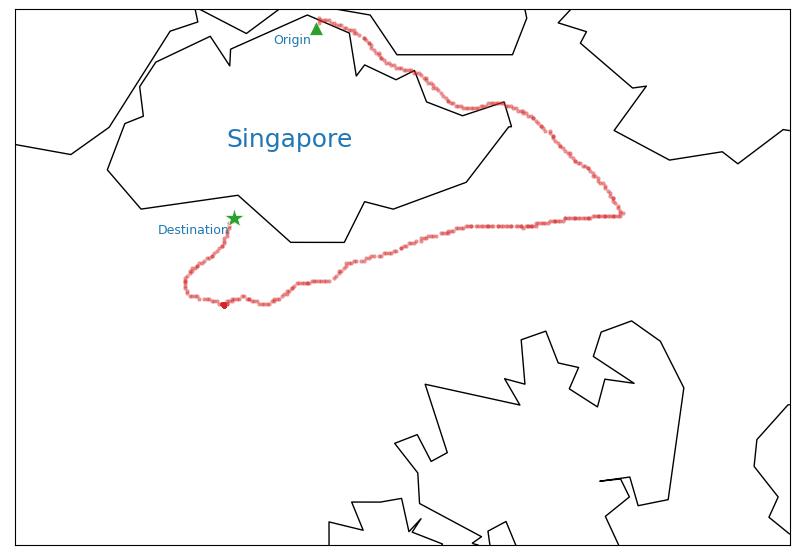

In [11]:
plt.style.use('default')

fig = plt.figure(figsize=(10, 10))
m = Basemap(projection='lcc', 
            width=width+1000, height=height+1000, 
            lat_0=hlat.mean(), lon_0=hlon.mean(), 
            resolution='i', )
# m.shadedrelief(scale=0.5, alpha=1)
m.drawcoastlines()

x, y = m(clon, clat)
plt.text(x-5000, y+15000, 'Singapore', fontsize=18, ha='right', va='top', c='C0')

for lat, lon in traces[route]:
    x, y = m(lon, lat)
    plt.plot(x, y, 'o', markersize=3, alpha=0.5, mew=0, c='C3')

x, y = m(*traces[route][0][::-1])
plt.plot(x, y, '^', markersize=10, mec='w', mew=0.5, c='C2')
plt.text(x-500, y-500, 'Origin', fontsize=9, ha='right', va='top', c='C0')
x, y = m(*traces[route][-1][::-1])
plt.plot(x, y, '*', markersize=15, mec='w', mew=0.5, c='C2')
plt.text(x-500, y-500, 'Destination', fontsize=9, ha='right', va='top', c='C0')

plt.savefig(os.path.join('img', f"route_{route}_illustrated.png"))
plt.show()

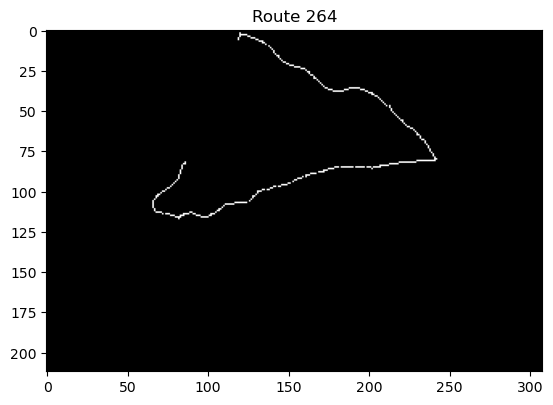

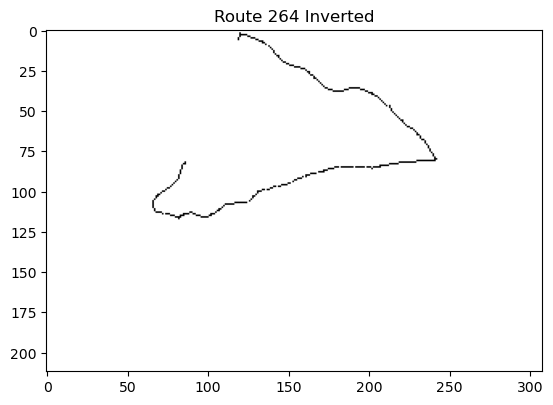

In [12]:
# The transformation of trace to route image

plt.imshow(routes[route], cmap='gray')
plt.title(f"Route {route}")
plt.imsave(os.path.join('img', f"route_{route}.png"), routes[route], cmap='gray')
plt.show()

plt.imshow(255-routes[route], cmap='gray')
plt.title(f"Route {route} Inverted")
plt.imsave(os.path.join('img', f"route_{route}_inverted.png"), 255-routes[route], cmap='gray')
plt.show()

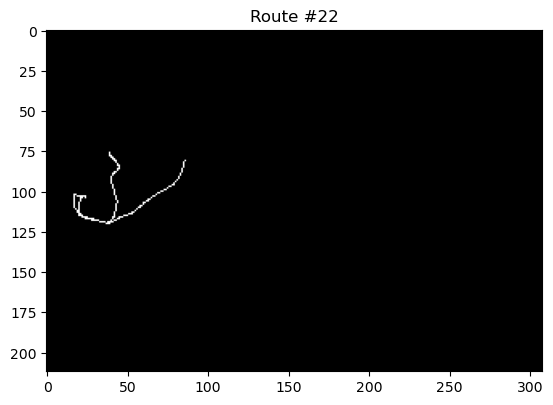

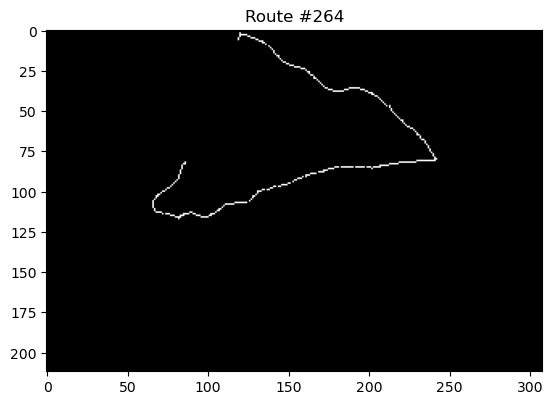

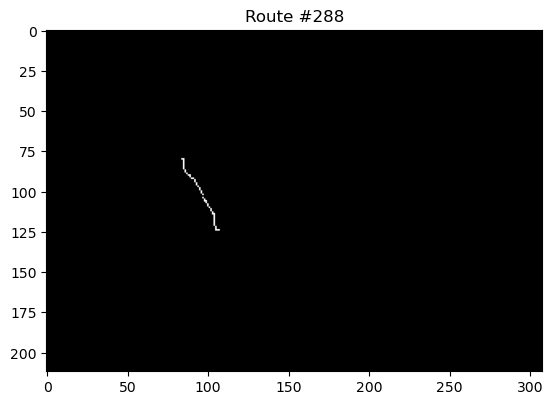

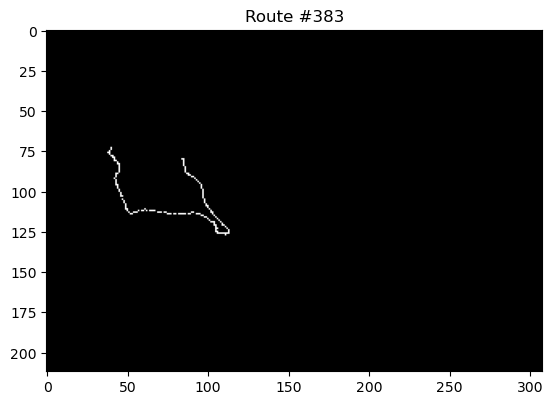

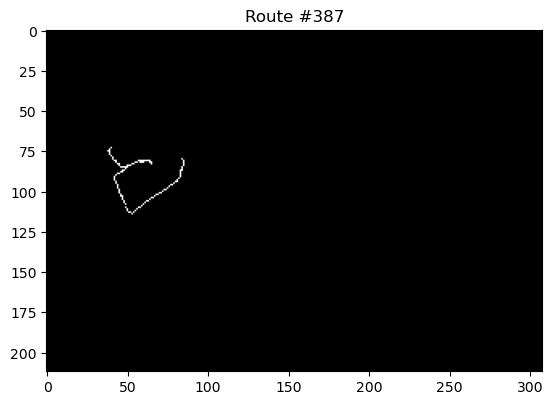

In [13]:
# Choose and view route images (jobs) as test dataset
# These routes/jobs are excluded during training/construction of models

test = [22, 264, 288, 383, 387]

for t in test:
    plt.title(f"Route #{t}")
    plt.imshow(routes[t], cmap='gray')
    plt.imsave(os.path.join('img', f"test_{t}.png"), routes[t], cmap='gray')
    plt.imsave(os.path.join('img', f"test_{t}_inverted.png"), 255-routes[t], cmap='gray')
    plt.show()

In [14]:
# Duplicating, randomizing/shuffling, and normalizing route image dataset
# Use job numbers other than in test, duplicate by 30 to 50 times, then shuffle

indices = np.concatenate([i * np.ones(np.random.randint(30,50)) for i in range(len(traces)) if i not in test]).astype(np.int32)
np.random.shuffle(indices)

ds_img = routes[indices]
ds_img = np.expand_dims(ds_img, -1).astype("float32")
ds_img = ds_img/ds_img.max()

print('Number of image in image dataset:', ds_img.shape, '<--- (n_images, pixel_height, pixel_width, 1)')
print('Range of values in image dataset:', ds_img.min(), 'to', ds_img.max())

Number of image in image dataset: (15763, 212, 308, 1) <--- (n_images, pixel_height, pixel_width, 1)
Range of values in image dataset: 0.0 to 1.0


In [15]:
# Choose/define latent dimension of latent representation

latent_dim = 7

In [16]:
# Run this cell to load the saved/trained VAE model

vae = VAE()
vae.encoder = tf.keras.models.load_model('enco.h5', compile=False, custom_objects={'Sampling': Sampling})
vae.decoder = tf.keras.models.load_model('deco.h5', compile=False)

2022-04-05 23:29:12.209578: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# Only run this cell to train a new model (multi GPU strategy)

# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
    
#     vae = VAE()

#     encoder_inputs = tf.keras.Input(shape=(212, 308, 1), name='Encoder_Input')
#     x = tf.keras.layers.Conv2D(8, 8, activation="relu", strides=2, padding="same", name="Conv2d_1")(encoder_inputs)
#     x = tf.keras.layers.Conv2D(16, 8, activation="relu", strides=2, padding="same", name="Conv2d_2")(x)
#     x = tf.keras.layers.Flatten(name='Flatten')(x)
#     x = tf.keras.layers.Dense(16, activation="relu", name='Fully_Connected')(x)
#     z_mean = tf.keras.layers.Dense(latent_dim, name="Mean_Output")(x)
#     z_log_var = tf.keras.layers.Dense(latent_dim, name="LogVar_Output")(x)
#     z = Sampling(name='Sample_Output')([z_mean, z_log_var])
#     encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="Encoder")
#     vae.encoder = encoder

#     latent_inputs = tf.keras.Input(shape=(latent_dim,), name='Decoder_Input')
#     x = tf.keras.layers.Dense(16, activation="relu", name='Fully_Connected_1')(latent_inputs)
#     x = tf.keras.layers.Dense(53 * 77 * 16, activation="relu", name='Fully_Connected_2')(x)
#     x = tf.keras.layers.Reshape((53, 77, 16), name='Reshape')(x)
#     x = tf.keras.layers.Conv2DTranspose(16, 8, activation="relu", strides=2, padding="same", name='Conv2DT_1')(x)
#     x = tf.keras.layers.Conv2DTranspose(8, 8, activation="relu", strides=2, padding="same", name='Conv2DT_2')(x)
#     decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same", name='Decoder_Output')(x)
#     decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="Decoder")
#     vae.decoder = decoder

#     # vae.encoder = tf.keras.models.load_model('enc_.h5', compile=False, custom_objects={'Sampling': Sampling})
#     # vae.decoder = tf.keras.models.load_model('dec_.h5', compile=False)
    
#     vae.compile(optimizer=tf.keras.optimizers.Adam(0.001))

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder_Input (InputLayer)     [(None, 212, 308, 1  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1 (Conv2D)              (None, 106, 154, 8)  520         ['Encoder_Input[0][0]']          
                                                                                                  
 Conv2d_2 (Conv2D)              (None, 53, 77, 16)   8208        ['Conv2d_1[0][0]']               
                                                                                                  
 Flatten (Flatten)              (None, 65296)        0           ['Conv2d_2[0][0]']         

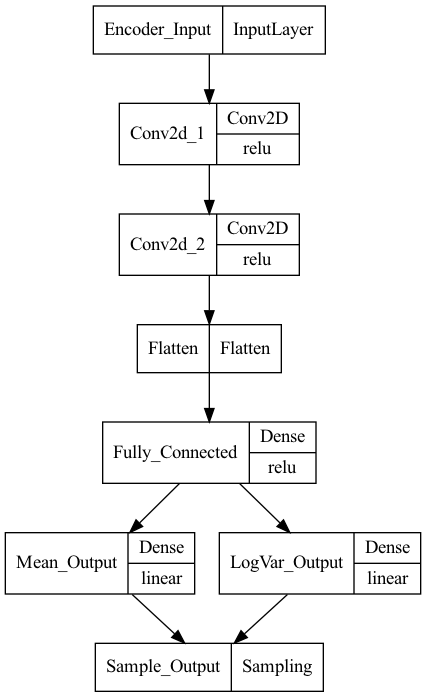

In [18]:
# View VAE's encoder architecture and details

vae.encoder.summary()

tf.keras.utils.plot_model(vae.encoder, 
                        #   to_file='encoder_network.png', 
                          show_shapes=False, show_dtype=False, show_layer_names=True, 
                          rankdir='TB', expand_nested=False, dpi=96,
                          layer_range=None, show_layer_activations=True)


Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Decoder_Input (InputLayer)  [(None, 7)]               0         
                                                                 
 Fully_Connected_1 (Dense)   (None, 16)                128       
                                                                 
 Fully_Connected_2 (Dense)   (None, 65296)             1110032   
                                                                 
 Reshape (Reshape)           (None, 53, 77, 16)        0         
                                                                 
 Conv2DT_1 (Conv2DTranspose)  (None, 106, 154, 16)     16400     
                                                                 
 Conv2DT_2 (Conv2DTranspose)  (None, 212, 308, 8)      8200      
                                                                 
 Decoder_Output (Conv2DTrans  (None, 212, 308, 1)      73  

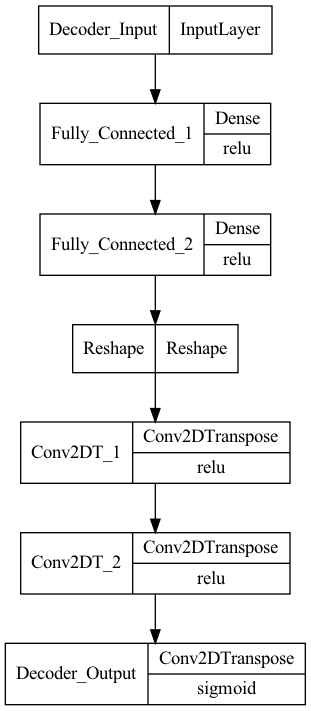

In [19]:
# View VAE's decoder architecture

vae.decoder.summary()

tf.keras.utils.plot_model(vae.decoder, 
                        #   to_file='decoder_network.png', 
                          show_shapes=False, show_dtype=False, show_layer_names=True, 
                          rankdir='TB', expand_nested=False, dpi=96,
                          layer_range=None, show_layer_activations=True)

In [20]:
# Only run this cell if training

# vae.fit(ds_img, epochs=100, batch_size=1024)

In [21]:
# Save the trained networks if necessary

# vae.encoder.save('enco.h5')
# vae.decoder.save('deco.h5')

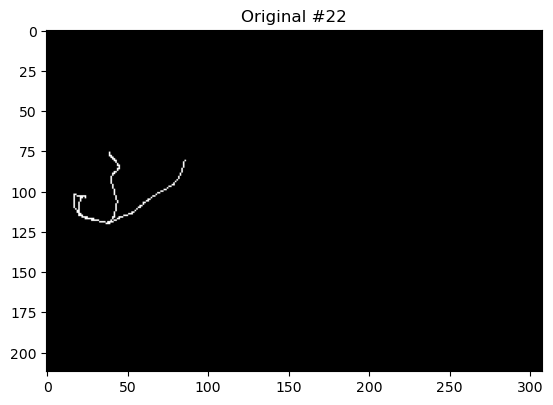

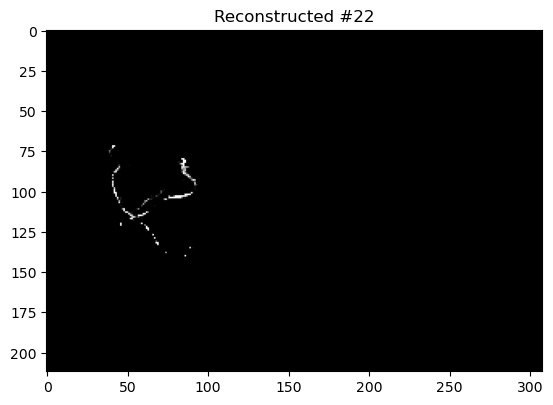

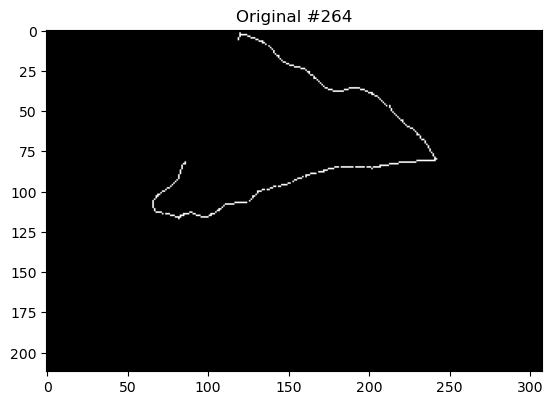

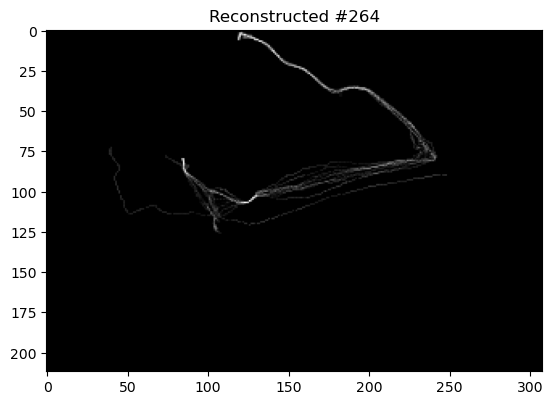

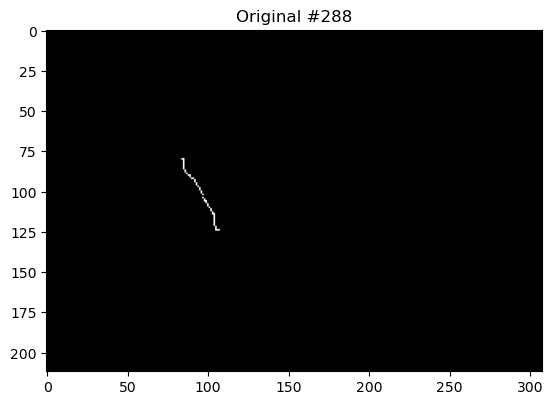

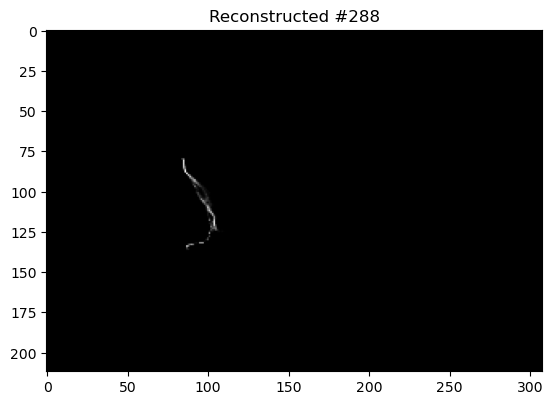

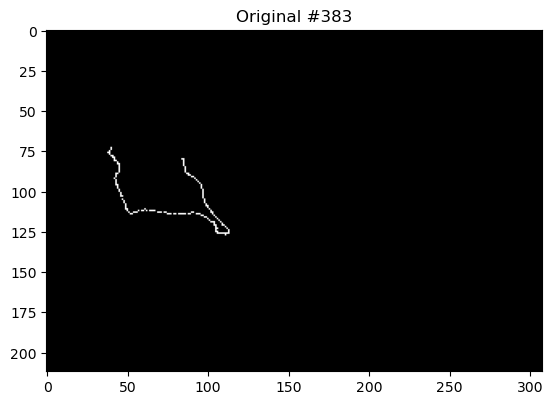

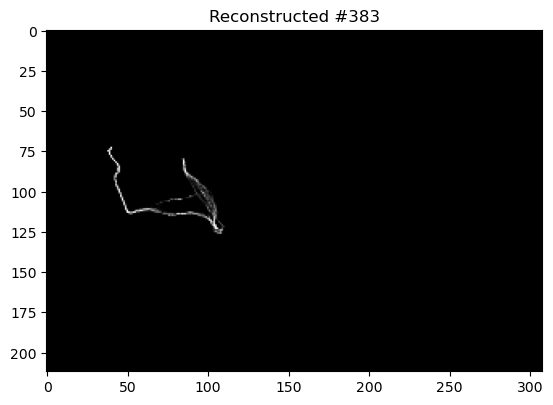

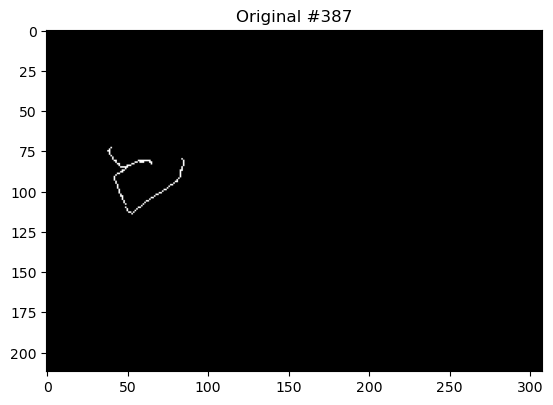

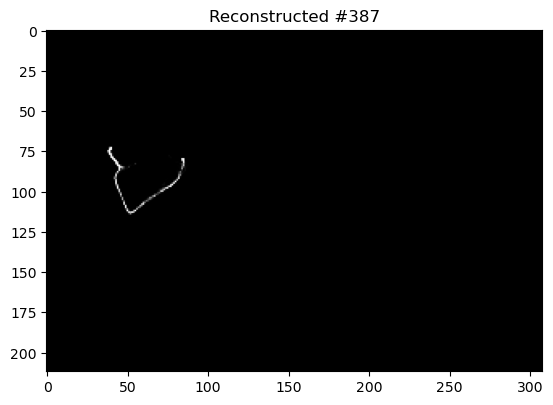

In [22]:
# Check the reconstruction of original routes (testing VAE performance)

for t in test:
    plt.title(f"Original #{t}")
    plt.imshow(routes[t], cmap='gray')
    # plt.imsave(os.path.join('img', f"original_{t}.png"), routes[t], cmap='gray')
    plt.show()
    # test vae model
    plt.title(f"Reconstructed #{t}")
    to_pred = np.expand_dims(routes[t],(0,3))
    to_pred = to_pred/to_pred.max()
    intermed_res = vae.encoder.predict(to_pred)
    for m_lv_z in zip(*intermed_res):
        for txt, el in zip(['mean', 'log_var', 'sample'], m_lv_z):
            # print(txt)
            img = np.squeeze(vae.decoder.predict(np.expand_dims(el,0)))
            plt.imshow(img, cmap='gray')
            if txt == 'mean':
                plt.imsave(os.path.join('img', f"vae_reconstructed_{t}.png"), img, cmap='gray')
                plt.imsave(os.path.join('img', f"vae_reconstructed_{t}_inverted.png"), 255-img, cmap='gray')
            plt.show()
            break

100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


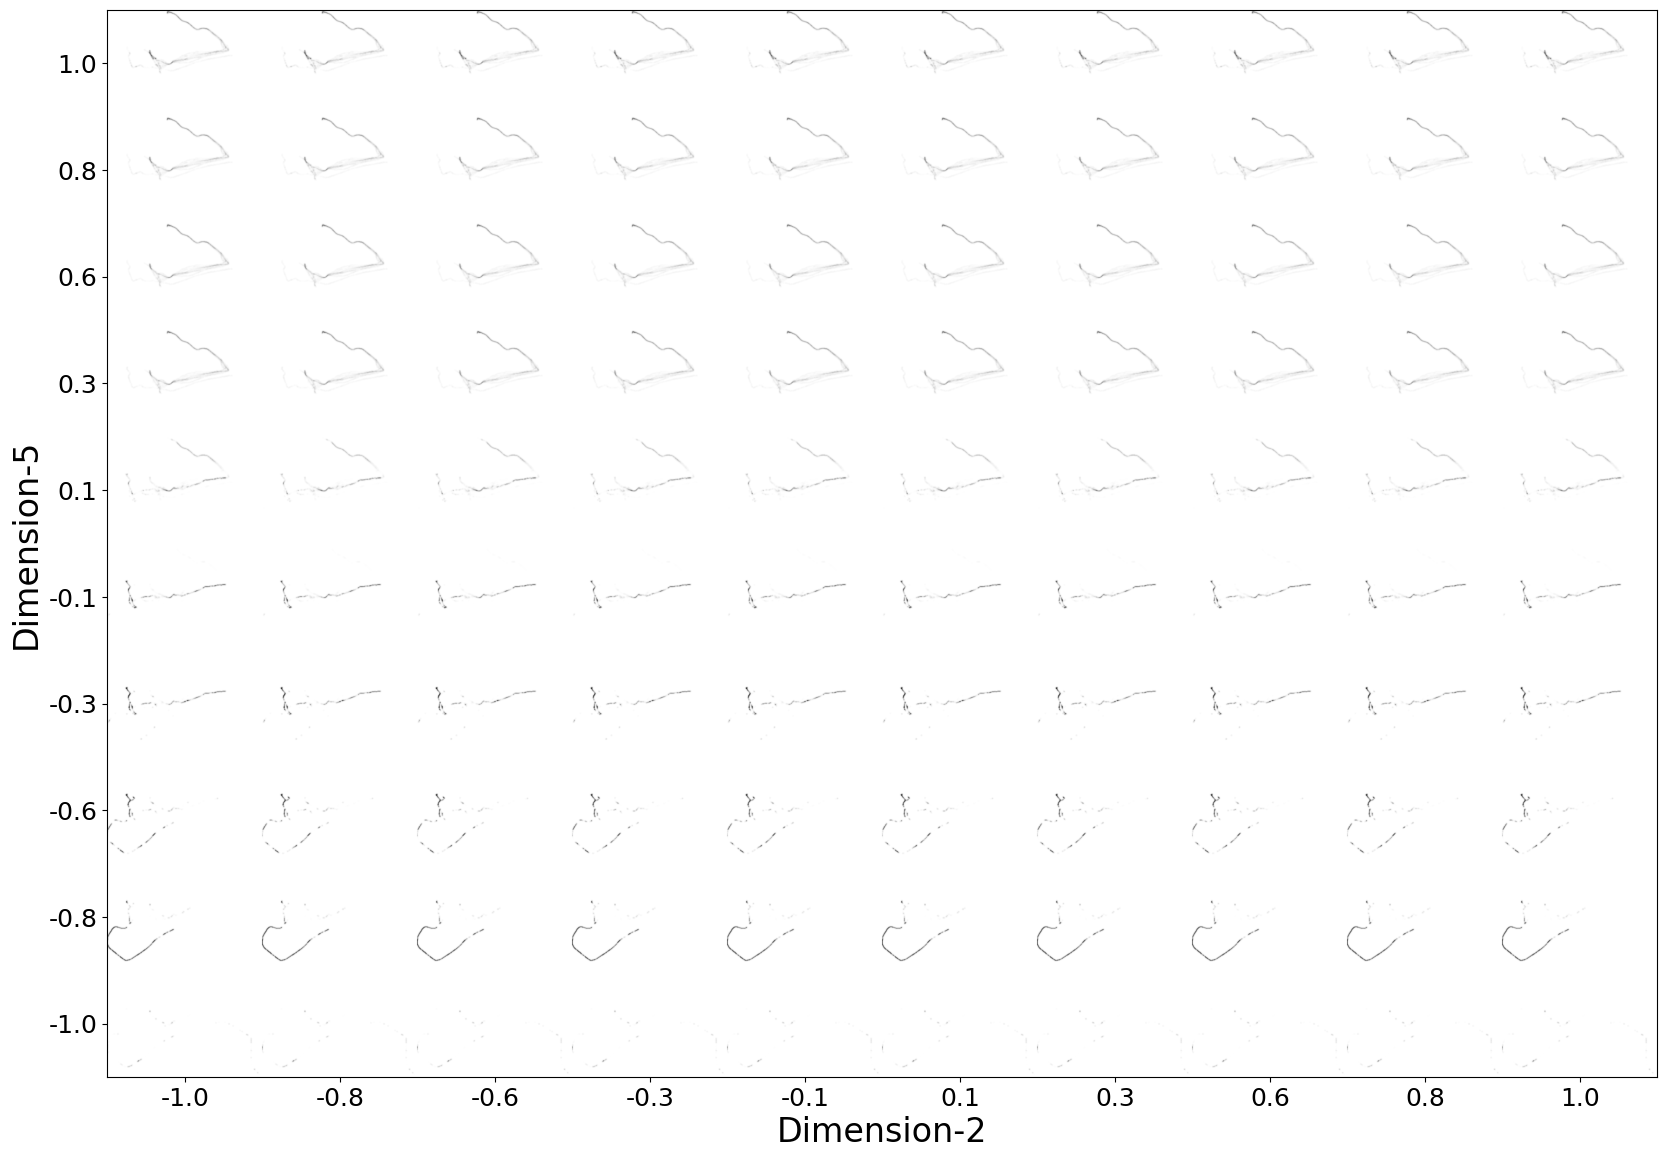

In [23]:
# Use decoder network to view a 2D slice of the latent space
# For latent_dim = 7

# slice2d=[-1,-0.5,'x',0,'y',0.5,1]
# slice2d=[-1,'x',1,0,'y',0,0]
slice2d=[0,'x',1,0,'y',-1,0]

plot_latent_space(vae, slice2d=slice2d)

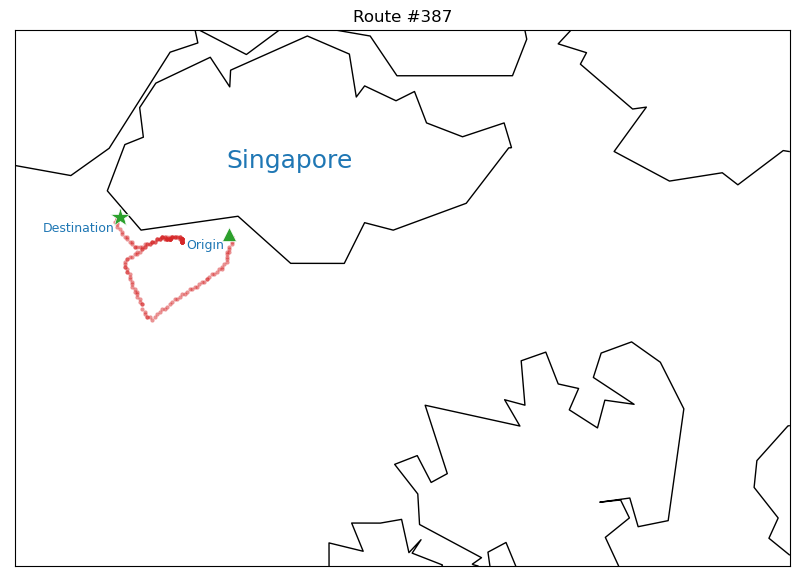

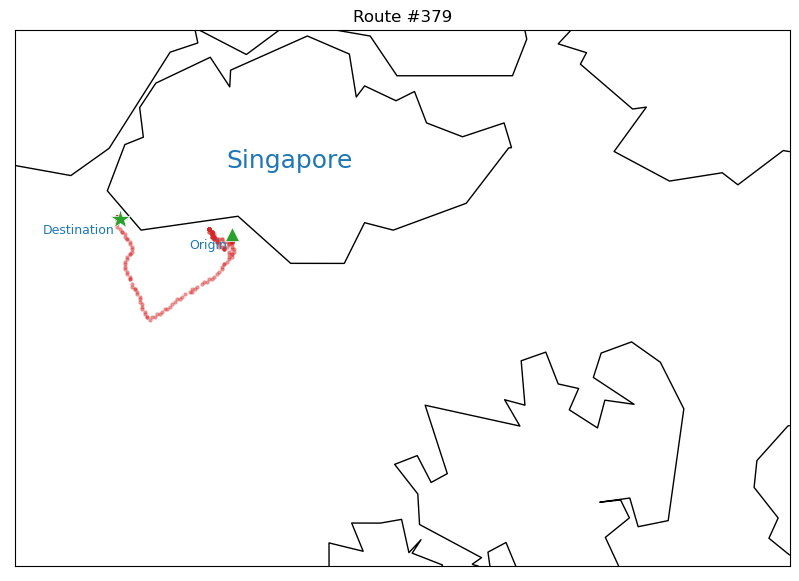

In [24]:
# Route similarity analysis

for t in [387, 379]:


    fig = plt.figure(figsize=(10, 10))
    m = Basemap(projection='lcc', 
                width=width+1000, height=height+1000, 
                lat_0=hlat.mean(), lon_0=hlon.mean(), 
                resolution='i', )
    # m.shadedrelief(scale=0.5, alpha=1)
    m.drawcoastlines()

    x, y = m(clon, clat)
    plt.text(x-5000, y+15000, 'Singapore', fontsize=18, ha='right', va='top', c='C0')

    for lat, lon in traces[t]:
        x, y = m(lon, lat)
        plt.plot(x, y, 'o', markersize=3, alpha=0.5, mew=0, c='C3')

    x, y = m(*traces[t][0][::-1])
    plt.plot(x, y, '^', markersize=10, mec='w', mew=0.5, c='C2')
    plt.text(x-500, y-500, 'Origin', fontsize=9, ha='right', va='top', c='C0')
    x, y = m(*traces[t][-1][::-1])
    plt.plot(x, y, '*', markersize=15, mec='w', mew=0.5, c='C2')
    plt.text(x-500, y-500, 'Destination', fontsize=9, ha='right', va='top', c='C0')

    plt.title(f"Route #{t}")
    plt.show()

Latitude dynamic time-warping


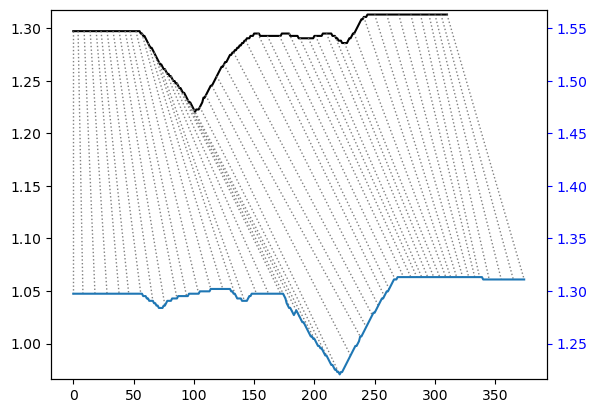

Longitude dynamic time-warping


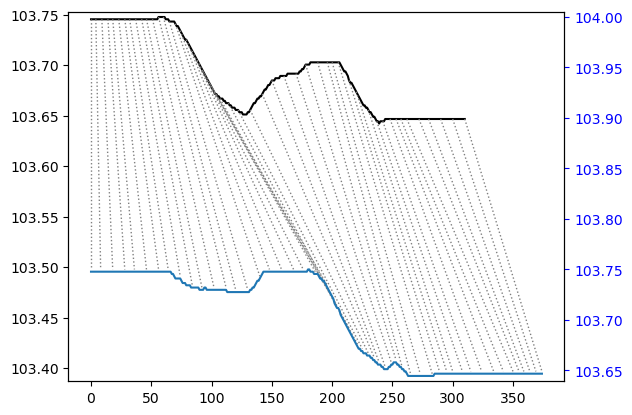

In [25]:
# break down the coordinates into latitude (lat) and longitude (lon), and
# match analyze similarity separately
# use dynamic time-warping to find accumulated distance between each route's lat and lon
# assume that lat and long are orthogonal, find hypothenuse for final distance value

a, b = traces[387], traces[379]

print('Latitude dynamic time-warping')
ax_lat = dtw(a[:,0],b[:,0], keep_internals=True, step_pattern=rabinerJuangStepPattern(3, "c")).plot(type="twoway", offset=-0.25)
print('Longitude dynamic time-warping')
ax_lon = dtw(a[:,1],b[:,1], keep_internals=True, step_pattern=rabinerJuangStepPattern(3, "c")).plot(type="twoway", offset=-0.25)


In [26]:
# This cell takes some time to run
# To build distance matrix from scratch from traces
# Otherwise, use `dist_mtx` loaded earlier from dataset.pkl

# dist_mtx = np.empty([len(traces),len(traces)])
# dist_mtx[:] = np.nan
# for (r,c), (a,b) in tqdm(zip(combinations(np.arange(len(traces)),2), combinations(traces,2)), file=sys.stdout, total=81810):
#     if a.shape[0]<= 1 or b.shape[0] <= 1:
#         d = np.inf
#     else:
#         # distance = dtw(a[:,0],b[:,0]).distance + dtw(a[:,1],b[:,1]).distance
#         d = np.hypot(dtw(a[:,0],b[:,0]).distance, dtw(a[:,1],b[:,1]).distance)
#     dist_mtx[r,c] = d
#     dist_mtx[c,r] = d
# dist_mtx

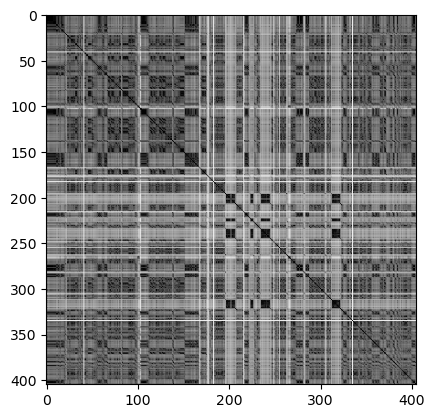

In [27]:
# Visualize the distance matrix
# 405 x 405 pair distances
# Bright areas are the traces with high value of distance

dist_mtx_visualized = dist_mtx.copy()
dist_mtx_visualized[np.isnan(dist_mtx_visualized)] = 0
dist_mtx_visualized[np.isinf(dist_mtx_visualized)] = np.sort(np.unique(dist_mtx_visualized.flatten()))[-3]

plt.imshow(np.log10(dist_mtx_visualized+1), cmap='gray')
plt.show()

In [28]:
# Take care of invalid numbers, nan (zero divides zero) and inf (division by zero)

dist_mtx[np.isnan(dist_mtx)] = 0
# dist_mtx[np.isinf(dist_mtx)] = np.finfo('d').max
dist_mtx[np.isinf(dist_mtx)] = np.iinfo(np.int16).max

In [29]:
# Perform agglomerative clustering using distance matrix
# Use either distance_threshold or number of n_clusters

# ahc = AgglomerativeClustering(n_clusters=45, affinity='precomputed', linkage='complete', distance_threshold=None)
ahc = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='complete', distance_threshold=3.5)
# ahc = AgglomerativeClustering(n_clusters=12, affinity='precomputed', linkage='complete', distance_threshold=None)
ahc.fit(dist_mtx)
print('Number of clusters:', ahc.labels_.max() + 1)

Number of clusters: 90


For route #387


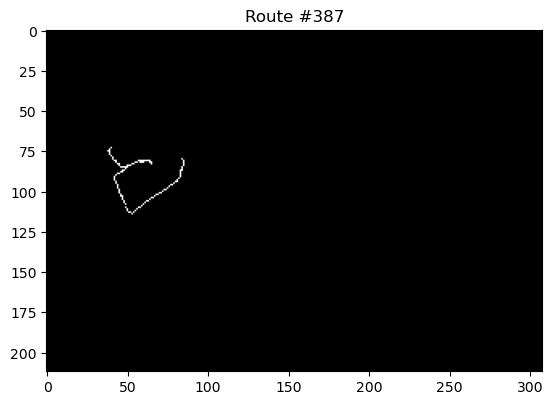

Other similar routes found:


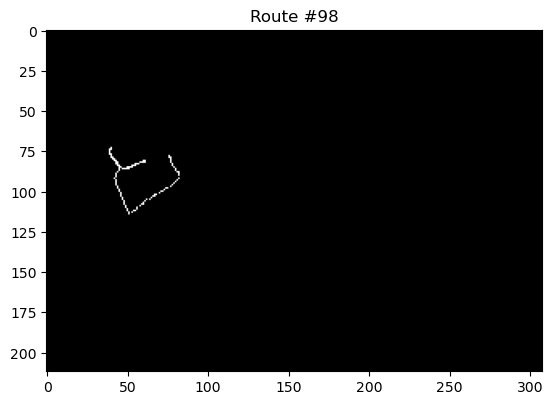

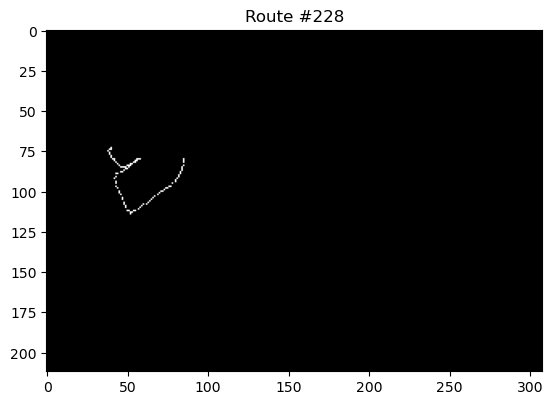

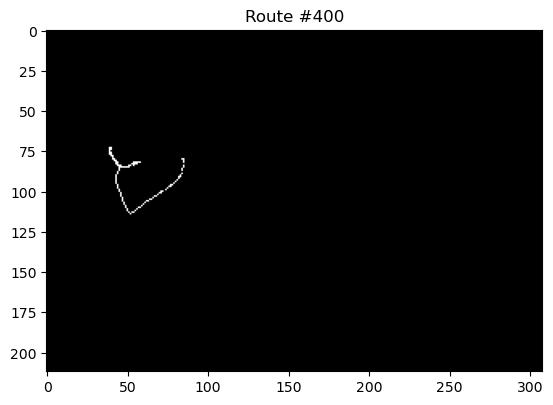

The aggregate of #98, #228, #387, #400


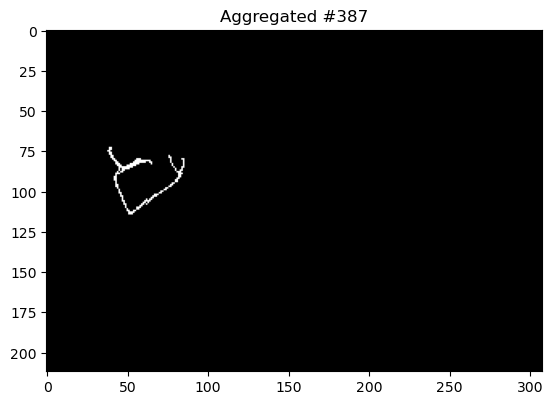

In [30]:
# Visualize clustering result

route = 387

print(f"For route #{route}")
plt.imshow(routes[route], cmap='gray')
plt.title(f"Route #{route}")
plt.show()

print('Other similar routes found:') 
aggregate = routes[route]
other_members = np.where(ahc.labels_==ahc.labels_[route])[0]
for i in other_members:
    if i == route:
        continue
    aggregate = aggregate + routes[i]
    plt.imshow(routes[i], cmap='gray')
    plt.title(f"Route #{i}")
    plt.show()

print('The aggregate of', ', '.join(['#'+str(member) for member in other_members]))
aggregate[aggregate>0] = 1
plt.imshow(aggregate, cmap='gray')
plt.title(f"Aggregated #{route}")
plt.imsave(os.path.join('img', f"aggregated_{route}.png"), aggregate, cmap='gray')
plt.imsave(os.path.join('img', f"aggregated_{route}_inverted.png"), 255-aggregate, cmap='gray')
plt.show()

In [31]:
# Check the X and y for the final model

feat = jobs.drop(columns=['start', 'stop'])
feat['class'] = ahc.labels_
feat['duration'] = feat['duration'].apply(lambda d: d.days*24*3600+d.seconds)
consumed = feat['consumed'].copy()
del feat['consumed']
feat['consumed'] = consumed
feat.columns = pd.MultiIndex.from_arrays([['X', 'X', 'X', 'X', 'X', 'X', 'y'], 
                                          ['Duration', 'Lat0', 'Lat1', 'Lon0', 'Lon1', 'Class', 'Fuel']])
feat

X                                                       y
    Duration      Lat0      Lat1        Lon0        Lon1 Class  Fuel
0       3600  1.310971  1.310971  103.646698  103.646698    10   190
1       4500  1.310971  1.310971  103.646698  103.646698    10   197
2      10800  1.310971  1.310971  103.646698  103.646698    10   570
3       7200  1.310971  1.310971  103.646698  103.646698    10   380
4       4200  1.310971  1.310971  103.646698  103.646698    10   195
..       ...       ...       ...         ...         ...   ...   ...
400    28800  1.220575  1.313231  103.644453  103.747721    20  1816
401     8400  1.283852  1.313231  103.644453  103.687107    25   455
402    10800  1.310971  1.313231  103.646698  103.646698    10   570
403    10800  1.310971  1.313231  103.646698  103.646698    10   570
404    10800  1.220575  1.313231  103.644453  103.696087     8   675

[405 rows x 7 columns]

In [32]:
# X_train and y_train

feat.columns = pd.MultiIndex.from_arrays([['X_train', 'X_train', 'X_train', 'X_train', 'X_train', 'X_train', 'y_train'], 
                                          ['Duration', 'Lat0', 'Lat1', 'Lon0', 'Lon1', 'Class', 'Fuel']])
feat_index = feat.index
feat_index.name = 'Job'
feat.index = feat_index
feat.iloc[~feat.index.isin(test)]

X_train                                                   y_train
    Duration      Lat0      Lat1        Lon0        Lon1 Class    Fuel
Job                                                                   
0       3600  1.310971  1.310971  103.646698  103.646698    10     190
1       4500  1.310971  1.310971  103.646698  103.646698    10     197
2      10800  1.310971  1.310971  103.646698  103.646698    10     570
3       7200  1.310971  1.310971  103.646698  103.646698    10     380
4       4200  1.310971  1.310971  103.646698  103.646698    10     195
..       ...       ...       ...         ...         ...   ...     ...
400    28800  1.220575  1.313231  103.644453  103.747721    20    1816
401     8400  1.283852  1.313231  103.644453  103.687107    25     455
402    10800  1.310971  1.313231  103.646698  103.646698    10     570
403    10800  1.310971  1.313231  103.646698  103.646698    10     570
404    10800  1.220575  1.313231  103.644453  103.696087     8     675

[400 rows x 7 columns]

In [33]:
# X_test and y_test

feat.columns = pd.MultiIndex.from_arrays([['X_test', 'X_test', 'X_test', 'X_test', 'X_test', 'X_test', 'y_test'], 
                                          ['Duration', 'Lat0', 'Lat1', 'Lon0', 'Lon1', 'Class', 'Fuel']])
feat.iloc[feat.index.isin(test)]

X_test                                                   y_test
    Duration      Lat0      Lat1        Lon0        Lon1 Class   Fuel
Job                                                                  
22     27000  1.207016  1.306451  103.595064  103.749966    46   1688
264    34800  1.213795  1.473683  103.705067  104.100178     9   2662
288     7200  1.197976  1.297411  103.745476  103.797110     1    450
383    21600  1.191196  1.313231  103.642208  103.810579    23   1310
387    19800  1.220575  1.313231  103.642208  103.747721    20   1245

In [34]:
# Build the feature network's y_train from vae model
# These are also the prediction network's X_train
# z prefixed variables are the intermediates (latent representation)

n_batch = 1000
z_mean, z_log_var, zs = vae.encoder.predict(ds_img[:1])
for i in tqdm(range(1, ds_img.shape[0], n_batch), file=sys.stdout, total=int(np.ceil((ds_img.shape[0]-1)/n_batch))):
    zm, zlv, z = vae.encoder.predict(ds_img[i:i+n_batch])
    z_mean, z_log_var, zs = np.append(z_mean, zm, axis=0), np.append(z_log_var, zlv, axis=0), np.append(zs, z, axis=0)
z_mean.shape, z_log_var.shape, zs.shape

100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


((15763, 7), (15763, 7), (15763, 7))

In [35]:
# Distance_threshold determines the number of route classes
# The lower it is, the better the fuel prediction is, at the expense of manual effort to select from higher number of classes
# The higher it is, the easier it is to manually select route pattern during deployment
# There is a sweetspot areas (near optimum) to find, not part of scope of this project

distance_threshold = 3.5
# distance_threshold = 10

In [36]:
# Build feature network X_train from jobs dataframe

# Extract and scale the duration from noon report and activity rectangle/area
ds_param = jobs[['lat0','lat1','lon0','lon1']].to_numpy()
ds_param = np.append(jobs['duration'].apply(lambda d: d.days*24*3600 + d.seconds).to_numpy().reshape(-1,1), ds_param, axis=1)
scaler = MinMaxScaler()
ds_param = scaler.fit_transform(ds_param)

# Classify routes and one-hot encode
ahc = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='complete', distance_threshold=distance_threshold)
ahc.fit(dist_mtx)
oh_enc_route = OneHotEncoder(sparse=False)
ds_class_route = oh_enc_route.fit_transform(ahc.labels_.reshape(-1,1))

# Combine the two sets (class and param), actually also includes test (is masked out during training)
combined = np.concatenate([ds_param, ds_class_route], axis=-1)

print('Number of metadata parameters:', ds_param.shape[1])
print('Number of route classes/clusters:', ahc.labels_.max() + 1)
print('Number of X_train parameters:', combined.shape[1])

Number of metadata parameters: 5
Number of route classes/clusters: 90
Number of X_train parameters: 95


In [37]:
# Build prediction network y_train from jobs dataframe

scaler_fuel = MinMaxScaler()
scaled_fuel = scaler_fuel.fit_transform(jobs[['consumed']].to_numpy())
scaled_fuel.shape

(405, 1)

In [38]:
# Check the dimension of X_train

ahc.labels_.max()+1,ds_param.shape[1]

(90, 5)

In [39]:
# Model object for inference

feature_prediction = FeaturePrediction(input_split=(ahc.labels_.max()+1,ds_param.shape[1]), latent_dim=latent_dim)
feature_prediction.feature_net = tf.keras.models.load_model('feat.h5', compile=False, custom_objects={'Sampling': Sampling})
feature_prediction.prediction_net = tf.keras.models.load_model('pred.h5', compile=False)

In [40]:
# Model object for training

# feature_prediction = FeaturePrediction(input_split=(ahc.labels_.max()+1,ds_param.shape[1]), latent_dim=latent_dim)
# feature_prediction.compile(optimizer=tf.keras.optimizers.Adam(0.001))

Model: "Feature"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Layer_1 (InputLayer)     [(None, 90, 1)]      0           []                               
                                                                                                  
 Conv1D (Conv1D)                (None, 1, 5)         455         ['Input_Layer_1[0][0]']          
                                                                                                  
 Flatten (Flatten)              (None, 5)            0           ['Conv1D[0][0]']                 
                                                                                                  
 Input_Layer_2 (InputLayer)     [(None, 5)]          0           []                               
                                                                                            

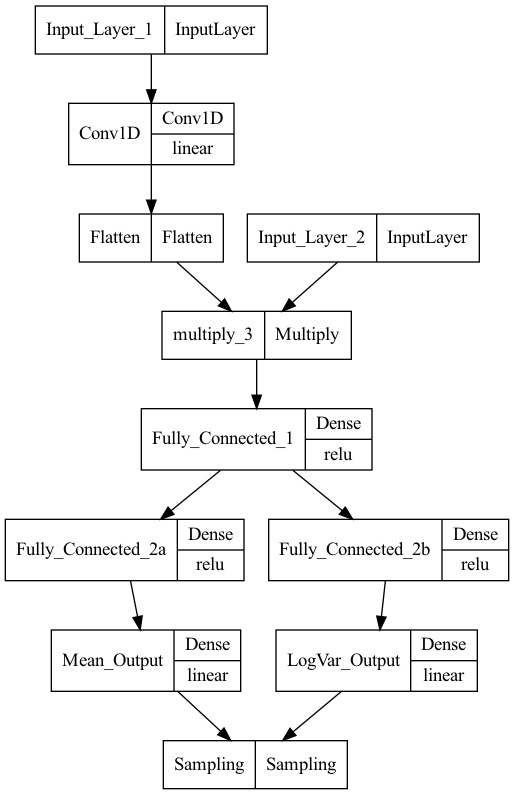

In [41]:
# View feature network architecture and details

feature_prediction.feature_net.summary()

tf.keras.utils.plot_model(feature_prediction.feature_net, 
                        #   to_file='feature_network.png', 
                          show_shapes=False, show_dtype=False, show_layer_names=True, 
                          rankdir='TB', expand_nested=False, dpi=96,
                          layer_range=None, show_layer_activations=True)

Model: "Predictor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Layer_A (InputLayer)     [(None, 7)]          0           []                               
                                                                                                  
 Input_Layer_B (InputLayer)     [(None, 7)]          0           []                               
                                                                                                  
 Fully_Connected_1a (Dense)     (None, 128)          1024        ['Input_Layer_A[0][0]']          
                                                                                                  
 Fully_Connected_1b (Dense)     (None, 128)          1024        ['Input_Layer_B[0][0]']          
                                                                                          

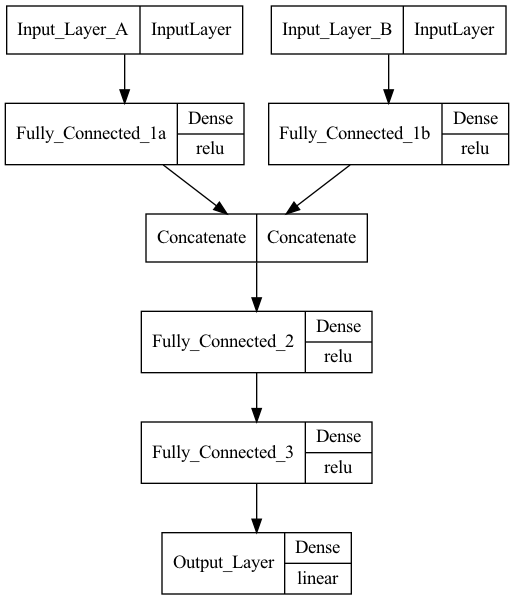

In [42]:
# View prediction network architecture and details

feature_prediction.prediction_net.summary()

tf.keras.utils.plot_model(feature_prediction.prediction_net, 
                        #   to_file='prediction_network.png', 
                          show_shapes=False, show_dtype=False, show_layer_names=True, 
                          rankdir='TB', expand_nested=False, dpi=96,
                          layer_range=None, show_layer_activations=True)

In [43]:
# Run this cell to train the feature/prediction networks

# history = feature_prediction.fit(x=[np.expand_dims(ds_class_route[indices],2), ds_param[indices]], 
#                                  y=[z_mean, z_log_var, scaled_fuel[indices]],
#                                  verbose=1, epochs=500, batch_size=8192)

In [44]:
# Save the trained networks if necessary

# feature_prediction.feature_net.save('feat.h5')
# feature_prediction.prediction_net.save('pred.h5')

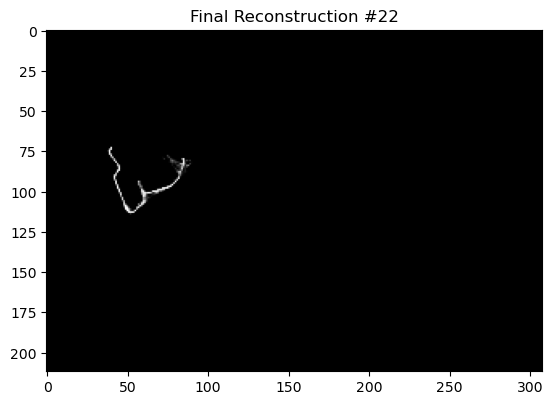

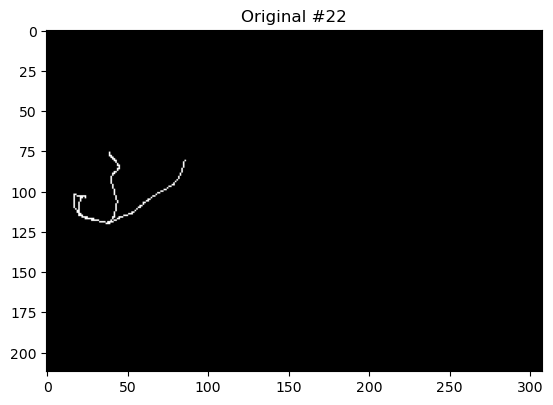

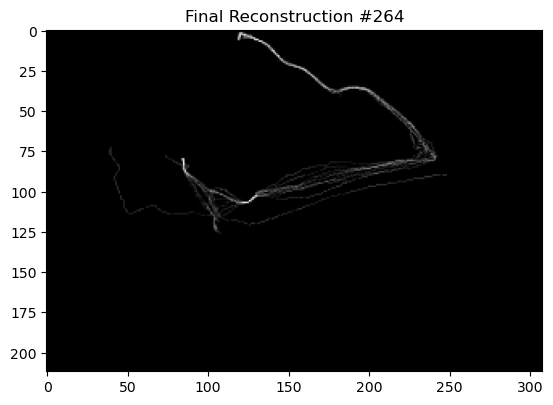

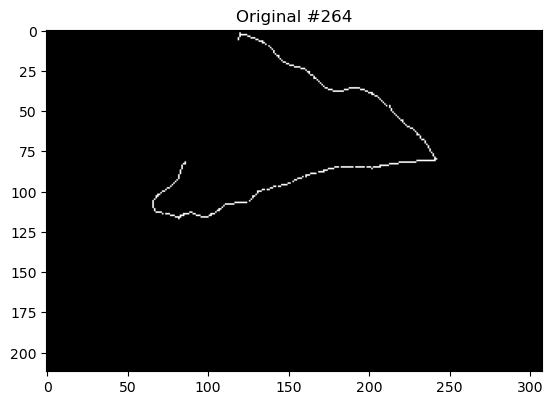

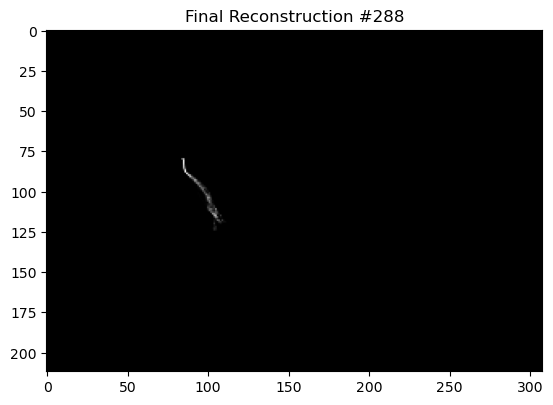

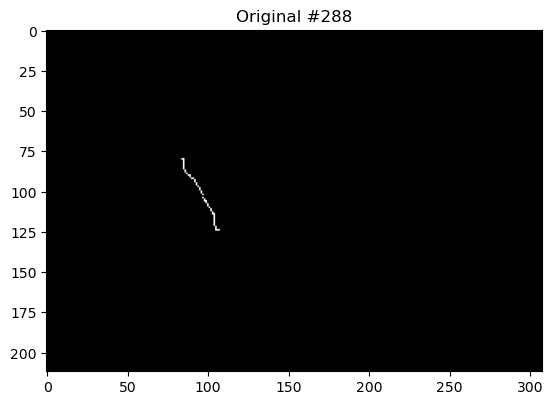

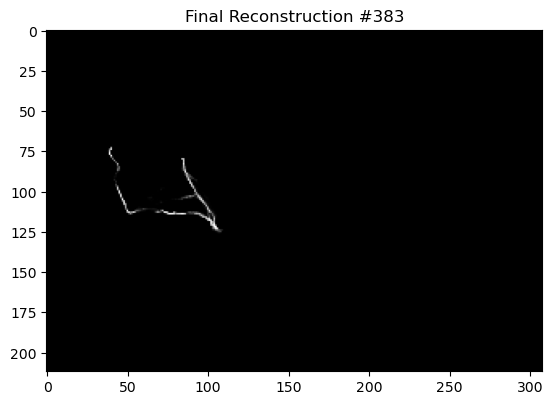

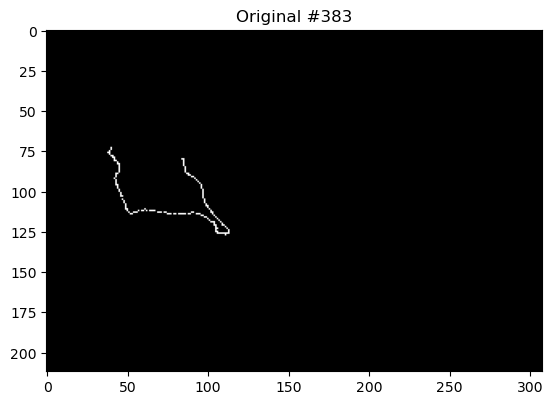

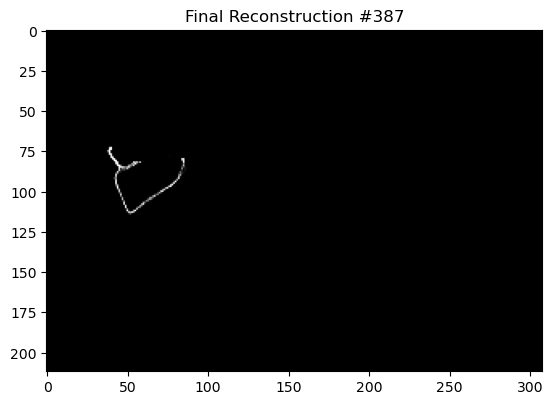

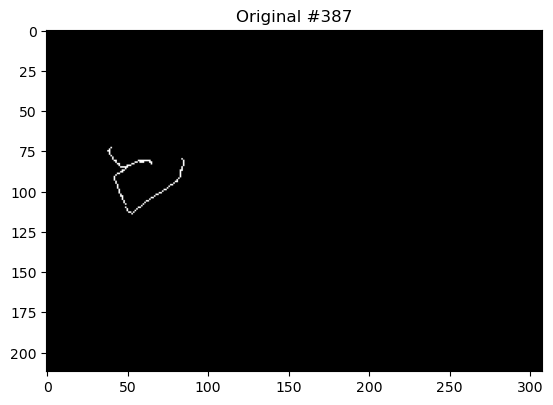

In [45]:
# The final route result for pathfinding
# Route reconstruction result using only job's metadata (and activity area) and route classification

for t in test:
    plt.title(f"Final Reconstruction #{t}")
    ct = combined[[t,]]
    mean, logvar, pred = feature_prediction.feature_net.predict([np.expand_dims(ct[:,5:],2),ct[:,:5]])
    pred = vae.decoder.predict(pred)
    pred_img = np.squeeze(pred.copy())
    plt.imshow(pred_img, cmap='gray')
    plt.imsave(os.path.join('img', f"final_{t}.png"), pred_img, cmap='gray')
    plt.imsave(os.path.join('img', f"final_{t}_inverted.png"), 255-pred_img, cmap='gray')
    plt.show()
    plt.title(f"Original #{t}")
    plt.imshow(np.squeeze(routes[t]), cmap='gray')
    plt.show()

In [46]:
# Final fuel prediction

ct = combined[test]
# m, lv = feature_prediction.feature_net.predict([np.expand_dims(ct[:,5:],2),ct[:,:5]])
m, lv, p = feature_prediction.feature_net.predict([np.expand_dims(ct[:,5:],2),ct[:,:5]])
fp = feature_prediction.prediction_net.predict([m, lv])
# fp = feature_prediction.prediction_net.predict(p)
fp = scaler_fuel.inverse_transform(fp)
results = []
for i, t in enumerate(test):
    a = scaled_fuel[t:t+1]
    a = scaler_fuel.inverse_transform(a)
    a = np.squeeze(a)
    p = np.squeeze(fp[i])
    # results.append([t,'\t',np.round(a).astype(np.int32),'\t',np.round(p).astype(np.int32),'\t',100*(p-a)/a,'\t'])
    results.append([t,np.round(a).astype(np.int32),np.round(p).astype(np.int32),np.round(100*(p-a)/a,2)])
# for r in results:
#     print(*r)
pd.DataFrame(results, columns=['Route', 'Observation', 'Prediction', '% Difference'])

,Route,Observation,Prediction,% Difference
0,22,1688,1309,-22.45
1,264,2662,2426,-8.88
2,288,450,454,0.78
3,383,1310,1419,8.28
4,387,1245,1094,-12.12


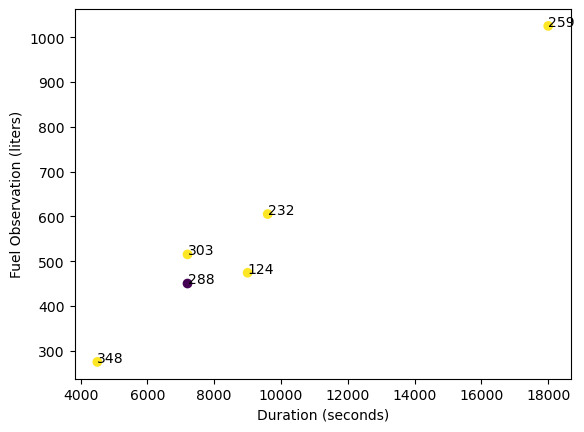

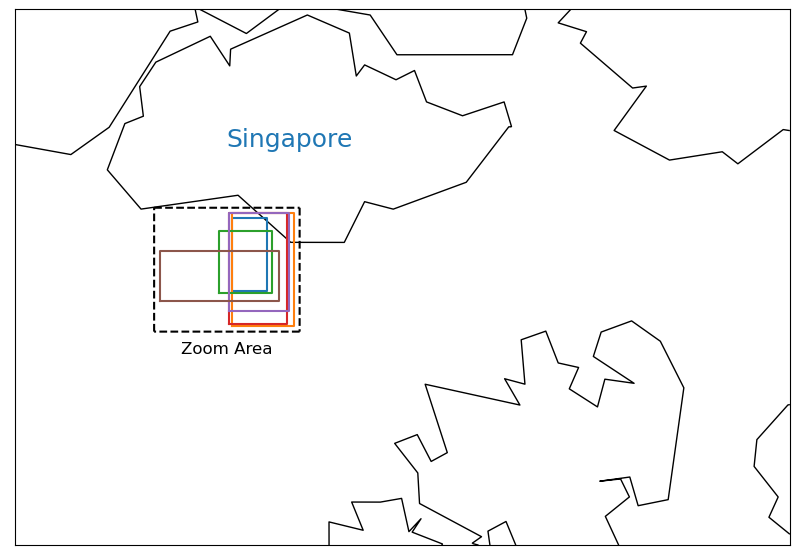

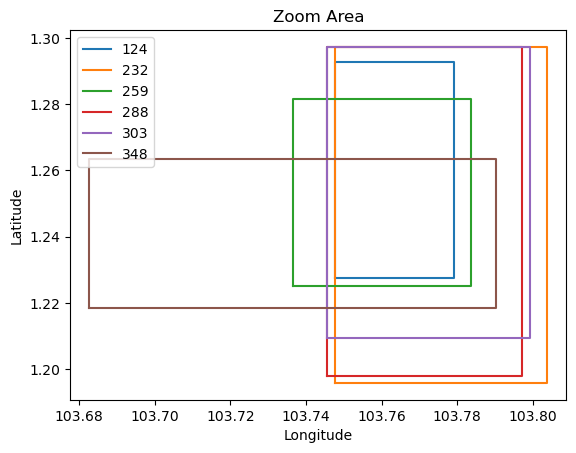

In [47]:
# Fuel prediction analysis
# Choose `route_num` to analyze the training/inference features

route_num = 288

class_members = np.where(ahc.labels_==ahc.labels_[route_num])[0]
duration = jobs.loc[jobs.index.isin(class_members),'duration'].apply(lambda d: d.days*24*3600+d.seconds).to_numpy()
obs_fuel = jobs.loc[jobs.index.isin(class_members),'consumed']
clr = np.ones(class_members.shape[0])
clr[np.where(class_members==route_num)[0]] = 0

plt.scatter(duration, obs_fuel, c=clr)
for x, y, text in zip(duration, obs_fuel, class_members):
    plt.text(x, y, text)
plt.xlabel('Duration (seconds)')
plt.ylabel('Fuel Observation (liters)')
plt.show()

fig = plt.figure(figsize=(10, 10))
m = Basemap(projection='lcc', 
            width=width+1000, height=height+1000, 
            lat_0=hlat.mean(), lon_0=hlon.mean(), 
            resolution='i', )
m.drawcoastlines()
x, y = m(clon, clat)
plt.text(x-5000, y+15000, 'Singapore', fontsize=18, ha='right', va='top', c='C0')
lats, lons = [], []
padding = 0.005
activity_areas = scaler.inverse_transform(combined[class_members,:5])[:,1:]
for i, ((lat0, lat1), (lon0, lon1), text) in enumerate(zip(activity_areas[:,:2], activity_areas[:,2:], class_members)):
    plt.plot([lon0, lon1, lon1, lon0, lon0], [lat0, lat0, lat1, lat1, lat0], c=f"C{i}", label=text)
    lats.extend([lat0-padding, lat1+padding])
    lons.extend([lon0-padding, lon1+padding])
lats, lons = sorted(lats), sorted(lons)
latlon = [(lats[0], lons[0]), (lats[-1], lons[0]), (lats[-1], lons[-1]), (lats[0], lons[-1])]
latlon += latlon[:1]
xborder, yborder = [], []
for (lat0, lon0), (lat1, lon1) in zip(latlon[:-1], latlon[1:]):
    x0, y0 = m(lon0, lat0)
    x1, y1 = m(lon1, lat1)
    plt.plot([x0, x1], [y0, y1], '--', markersize=5, alpha=1, c='k')
plt.text(np.mean([x0,x1]), np.mean([y0,y1])-1000, 'Zoom Area', fontsize=12, ha='center', va='top', c='k')
for i, ((lat0, lat1), (lon0, lon1), text) in enumerate(zip(activity_areas[:,:2], activity_areas[:,2:], class_members)):
    x0, y0 = m(lon0, lat0)
    x1, y1 = m(lon1, lat1)
    plt.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], c=f"C{i}", label=text)
plt.show()

for i, ((lat0, lat1), (lon0, lon1), text) in enumerate(zip(activity_areas[:,:2], activity_areas[:,2:], class_members)):
    plt.plot([lon0, lon1, lon1, lon0, lon0], [lat0, lat0, lat1, lat1, lat0], c=f"C{i}", label=text)
plt.xlim(lons[::len(lons)-1])
plt.ylim(lats[::len(lats)-1])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='best')
plt.title('Zoom Area')
plt.show()

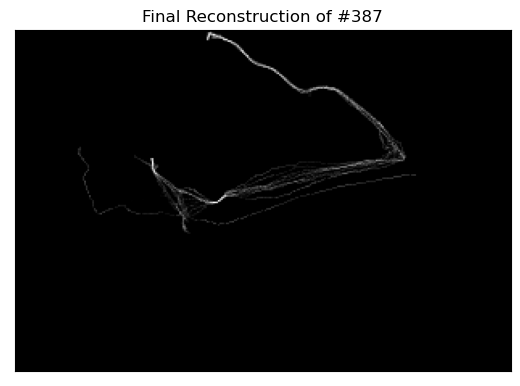

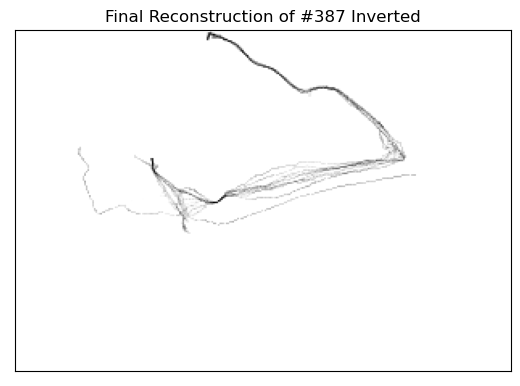

In [48]:
# Select one route for pathfinding

route = 264

ct = combined[[route,]]
mean, logvar, pred = feature_prediction.feature_net.predict([np.expand_dims(ct[:,5:],2),ct[:,:5]])
pred = vae.decoder.predict(pred)
pred_cost = np.squeeze(pred.copy())

plt.imshow(pred_cost, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title(f"Final Reconstruction of #{t}")
plt.show()

inverted = -np.log(pred_cost+1)
inverted[np.isinf(inverted)] = np.sort(np.unique(inverted))[-2]

plt.imshow(inverted, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title(f"Final Reconstruction of #{t} Inverted")
plt.show()

In [49]:
# Convert trace's continuous lat/lon into discrete

grid = np.array(list(product(hlat, hlon)))
glonlat = []
for pt in traces[route]:
    d = np.linalg.norm(grid-pt, axis=1)
    lat_closest, lon_closest = grid[np.where(d==d.min())[0][0]]
    lat_closest, lon_closest = np.where(hlat==lat_closest)[0][0], np.where(hlon==lon_closest)[0][0]
    glonlat.append([lon_closest, lat_closest])
glonlat = np.array(glonlat)
glonlat[:,1] = hlat.shape[0] - glonlat[:,1]
glonlat.shape

(552, 2)

In [50]:
# convert reconstruction route image into cost map
# cost map takes 0 as no go zone
# 1 is maximum cost
# value between 0 to 1 are the cost/multiplier visiting a node

cost_map = pred_cost.copy()
maxim = cost_map.max()
cost_map = maxim - cost_map
cost_map[cost_map==maxim] = 0
# cost_map = cost_map**100
cost_map = cost_map / cost_map.max()
cost_map.shape, cost_map.min(), cost_map.max()

((212, 308), 0.0, 1.0)

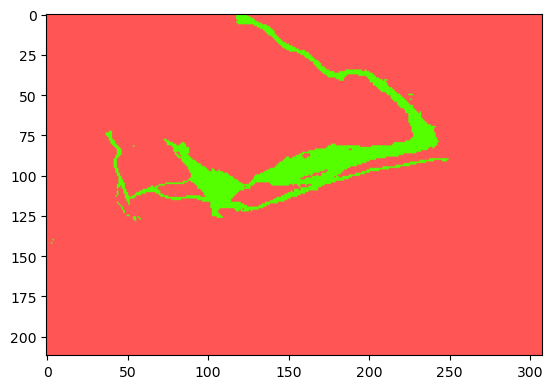

In [51]:
# visualize the cost map

is_show_traces = False
cost_map_viz = np.expand_dims(cost_map.copy(),2)
rviz = cost_map_viz.copy()
gviz = cost_map_viz.copy()
bviz = cost_map_viz.copy()
# no go zone
rviz[cost_map_viz==0] = 1
rviz[cost_map_viz!=0] = 0
gviz[cost_map_viz==0] = 0
bviz[cost_map_viz==0] = 0
# go zone
if is_show_traces:
    gviz[cost_map_viz!=0] = gviz[cost_map_viz!=0] - 1/3
else:
    gviz[cost_map_viz!=0] = 1/gviz[cost_map_viz!=0]
bviz[cost_map_viz!=0] = -1/3
cost_map_viz = np.concatenate([rviz,gviz,bviz], axis=2)
cost_map_viz = cost_map_viz + 1/3
cost_map_viz[cost_map_viz>1] = 1
cost_map_viz[cost_map_viz<0] = 0
plt.imshow(cost_map_viz)
plt.imsave(os.path.join('img', f"cost_map_{t}.png"), cost_map_viz)
plt.show()

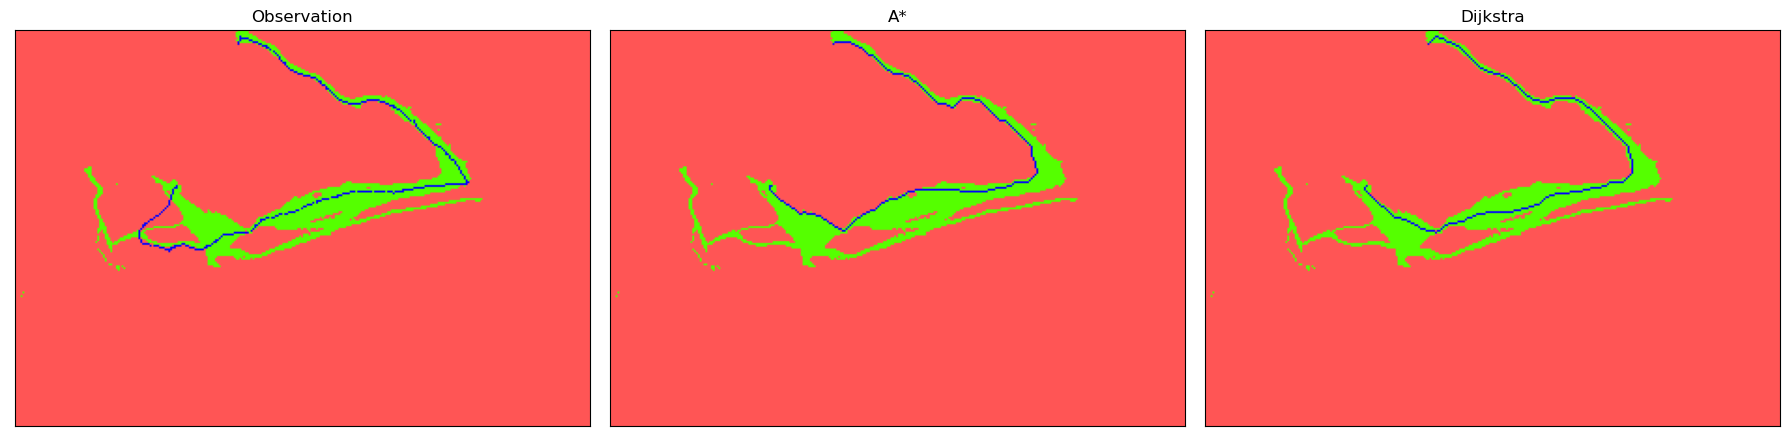

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6), tight_layout=True)

path_map = cost_map_viz.copy()
path_map[path_map>1] = 1
for c,r in glonlat:
    path_map[r,c,0] = 0
    path_map[r,c,1] = 0
    path_map[r,c,2] = 1
ax[0].imshow(path_map)
ax[0].title.set_text('Observation')
ax[0].set_xticks([])
ax[0].set_yticks([])

path_map = (1/(path_map+1))-1

x, y = glonlat[0]
origin = y, x
x, y = glonlat[-1]
target = y, x

pathfinder = Pathfinder(origin, target, cost_map, mode='A*', effect=None, diagonal=True)
pathfinder.run()
if pathfinder.is_solvable:
    path_map = cost_map_viz.copy()
    for r,c in pathfinder.path:
        path_map[r,c,0] = 0
        path_map[r,c,1] = 0
        path_map[r,c,2] = 1
    ax[1].imshow(path_map)
    ax[1].title.set_text('A*')
else:
    print('no solution')
    ax[1].imshow(cost_map.copy())
    ax[1].title.set_text('No Suggestion')
ax[1].set_xticks([])
ax[1].set_yticks([])

pathfinder = Pathfinder(origin, target, cost_map, mode='Dijkstra', effect=None, diagonal=True)
pathfinder.run()
if pathfinder.is_solvable:
    path_map = cost_map_viz.copy()
    for r,c in pathfinder.path:
        path_map[r,c,0] = 0
        path_map[r,c,1] = 0
        path_map[r,c,2] = 1
    ax[2].imshow(path_map)
    ax[2].title.set_text('Dijkstra')
else:
    print('no solution')
    ax[2].imshow(cost_map.copy())
    ax[2].title.set_text('No Suggestion')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.savefig(os.path.join('img', 'pathfinding_comparison.png'))
plt.show()

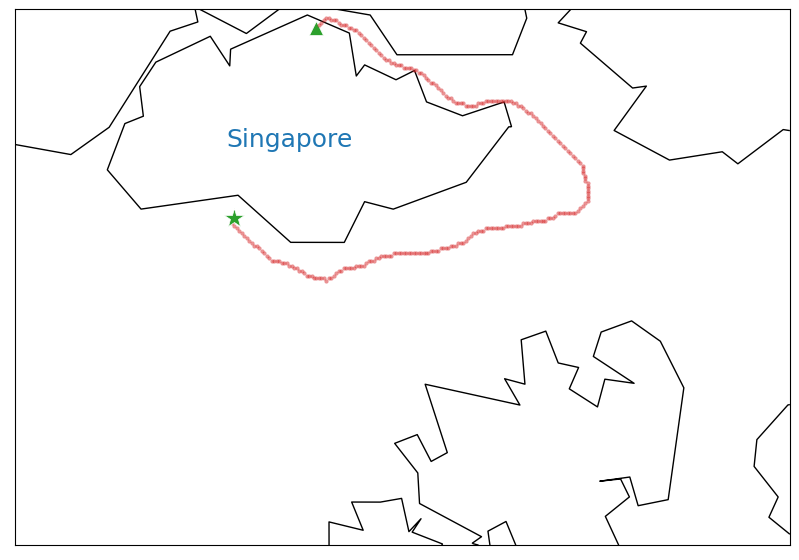

In [53]:
# suggested route from variable path

fig = plt.figure(figsize=(10, 10))
m = Basemap(projection='lcc', 
            width=width+1000, height=height+1000, 
            lat_0=hlat.mean(), lon_0=hlon.mean(), 
            resolution='i', )
# m.shadedrelief(scale=0.5, alpha=1)
m.drawcoastlines()

x, y = m(clon, clat)
plt.text(x-5000, y+15000, 'Singapore', fontsize=18, ha='right', va='top', c='C0')

for i, (lat, lon) in enumerate(pathfinder.path):
    lat, lon = hlat[hlat.shape[0]-lat], hlon[lon]
    x, y = m(lon, lat)
    plt.plot(x, y, 'o', markersize=3, alpha=0.5, mew=0, c='C3')
    if i == 0:
        plt.plot(x, y, '^', markersize=10, mec='w', mew=0.5, c='C2')
plt.plot(x, y, '*', markersize=15, mec='w', mew=0.5, c='C2')

plt.savefig(os.path.join('img', 'pathfinding_illustrated.png'))
plt.show()

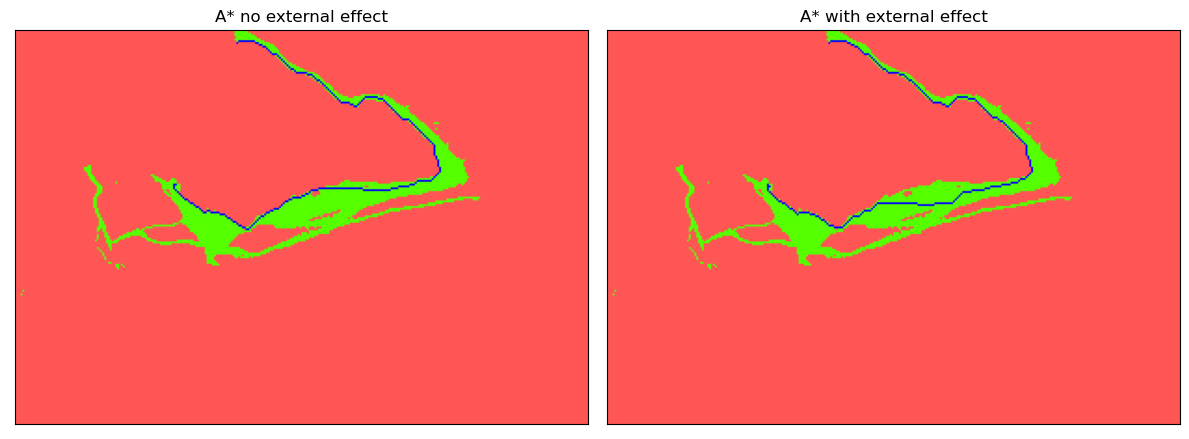

In [54]:
# application of effect map

# mode = 'Dijkstra'
mode = 'A*'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

path_map = cost_map.copy()  # for viewing only
path_map = (1/(path_map+1))-1

x, y = glonlat[0]
origin = y, x
x, y = glonlat[-1]
target = y, x

pathfinder = Pathfinder(origin, target, cost_map, mode=mode, effect=None, diagonal=True)
pathfinder.run()
if pathfinder.is_solvable:
    path_map = cost_map_viz.copy()
    for r,c in pathfinder.path:
        path_map[r,c,0] = 0
        path_map[r,c,1] = 0
        path_map[r,c,2] = 1
    ax[0].imshow(path_map, cmap='gray')
    ax[0].title.set_text(f"{mode} no external effect")
else:
    print('no solution')
    ax[0].imshow(cost_map.copy(), cmap='gray')
    ax[0].title.set_text('No Suggestion')
ax[0].set_xticks([])
ax[0].set_yticks([])
no_effect = pathfinder.path.copy()

effect_map = np.empty(cost_map.shape, dtype=np.complex64)
effect_map[:] = 3E5 + 4*np.pi*1j/4

pathfinder = Pathfinder(origin, target, cost_map, mode=mode, effect=effect_map, diagonal=True)
pathfinder.run()
if pathfinder.is_solvable:
    path_map = cost_map_viz.copy()
    for r,c in pathfinder.path:
        path_map[r,c,0] = 0
        path_map[r,c,1] = 0
        path_map[r,c,2] = 1
    ax[1].imshow(path_map, cmap='gray')
    ax[1].title.set_text(f"{mode} with external effect")
else:
    print('no solution')
    ax[1].imshow(cost_map.copy(), cmap='gray')
    ax[1].title.set_text('No Suggestion')
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()